# Importing libraries

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kumarakrishnavaleti/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df_train1 = pd.read_csv('/Users/kumarakrishnavaleti/desktop/PS1/emotions_dataset/train.txt', names=['Text', 'Emotion'], sep=';')
#df_train2 = pd.read_csv('/kaggle/input/emotion-dataset/training.csv', names=['Text', 'Emotion'], sep=';')
df_train3 = pd.read_csv('/Users/kumarakrishnavaleti/desktop/PS1/Emotion_final.csv', names=['Text', 'Emotion'], sep=',')
df_train3 = df_train3.drop(0)
df_train2 = pd.read_csv('/Users/kumarakrishnavaleti/desktop/PS1/emotions_dataset/val.txt', names=['Text', 'Emotion'], sep=';')
df_train4 = pd.read_csv('/Users/kumarakrishnavaleti/desktop/PS1/emotions_dataset/test.txt', names=['Text', 'Emotion'], sep=';')
df_train = pd.concat([df_train1, df_train2, df_train3, df_train4], ignore_index=True)



In [3]:
import tensorflow as tf
print(tf.__version__)

2.13.0-rc1


In [4]:
df_train['Emotion'] = df_train['Emotion'].replace('happy', 'joy')

In [5]:
# Shuffle the dataframe
df_train_shuffled = df_train.sample(frac=1, random_state=42)

# Split the shuffled dataframe into train, validation, and test sets
train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing

train_size = int(len(df_train_shuffled) * train_ratio)
val_size = int(len(df_train_shuffled) * val_ratio)

df_train = df_train_shuffled.iloc[:train_size]
df_val = df_train_shuffled.iloc[train_size:train_size+val_size]
df_test = df_train_shuffled.iloc[train_size+val_size:]

# Reset the indices of the split dataframes
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


In [6]:
#print first 5 rows
df_train.head()

,Text,Emotion
0,i never thought i could feel thankful for such...,joy
1,im feeling rather disheartened,sadness
2,i wasnt feeling very optimistic but this would...,joy
3,i said it when i read about people who are loo...,anger
4,i hope that one day i feel some sort of divine...,joy


In [7]:
#print the shape of the data set
print(df_train.shape)

(33167, 2)


In [8]:
#print first 5 rows
df_test.head()

,Text,Emotion
0,i feel helpless and scared and all of these th...,sadness
1,ive been hiding my eyes between tight hands ra...,love
2,i love about my job i still feel dissatisfied,anger
3,im feeling pretty annoyed with the whole thing...,anger
4,i feel so idiotic for letting you and myself c...,sadness


In [9]:
#print the shape of the data set
print(df_test.shape)

(4147, 2)


In [10]:
#print first 5 rows
df_val.head()

,Text,Emotion
0,i look back on that i feel amazed that at such...,surprise
1,i feel that the content i have in mind isnt re...,joy
2,i drive home i feel like a petty thief having ...,anger
3,i feel like a guilty sack of shit,sadness
4,i feel extremely lost right now,sadness


In [11]:
#print the shape of the data set
print(df_val.shape)

(4145, 2)


In [12]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

joy         10961
sadness      9681
anger        4591
fear         3997
love         2661
surprise     1276
Name: Emotion, dtype: int64

In [13]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

joy         33.047909
sadness     29.188651
anger       13.842072
fear        12.051135
love         8.023035
surprise     3.847198
Name: Emotion, dtype: float64

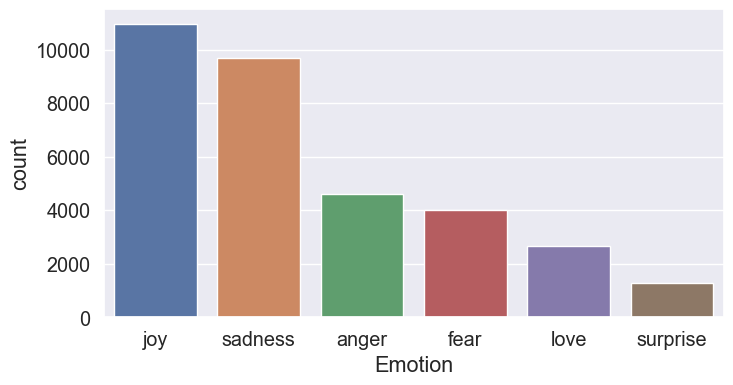

In [14]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_train);

The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [15]:
#print the number of null values in each column
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

The data doesn't contains any null values

In [16]:
#print the number of duplicated values 
df_train.duplicated().sum()

12814

In [17]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

/var/folders/hz/lcq0rx_90gq0lk9rm64pkzth0000gn/T/ipykernel_24926/1730637252.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(index, axis = 0, inplace = True)


In [18]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
3396,i feel that being faithful isnt enough in your...,joy
4958,i am feeling stressed and more than a bit anxious,sadness
6185,i had to choose the sleek and smoother feel of...,joy
6820,i feel im being generous with that statement,love
6875,i cant escape the tears of sadness and just tr...,love
7140,i often find myself feeling assaulted by a mul...,sadness
7564,i have chose for myself that makes me feel ama...,joy
7907,i feel like i am in paradise kissing those swe...,joy
8064,i write these words i feel sweet baby kicks fr...,joy
8760,i am not amazing or great at photography but i...,love


In [19]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
7623,i feel overwhelmed or a little blue usually ar...,fear


In [20]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]


,Text,Emotion
14313,i feel giggly,joy


In [21]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]


,Text,Emotion
13879,"All during the night , over and over again , s...",joy


In [22]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

/var/folders/hz/lcq0rx_90gq0lk9rm64pkzth0000gn/T/ipykernel_24926/2711179159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(index, axis = 0, inplace = True)


In [23]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

7     1815
5     1789
6     1781
4     1710
8     1684
3     1626
9     1530
10    1335
2     1204
11    1132
12     905
13     774
14     606
1      593
15     469
16     341
17     289
18     197
19     136
0      117
20     117
21      70
22      37
23      27
24       8
26       6
25       5
29       1
28       1
Name: stop_words, dtype: int64

<Axes: ylabel='Frequency'>

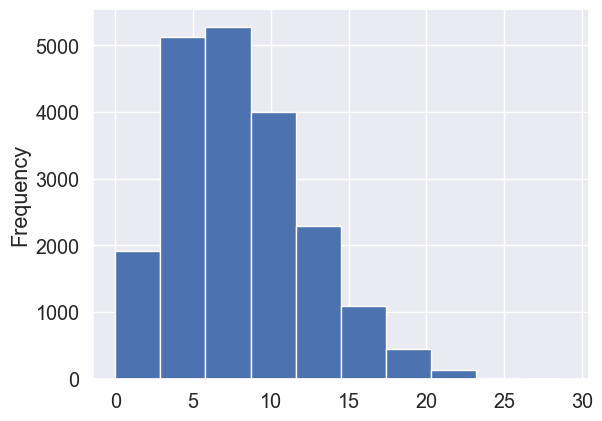

In [24]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')


In [25]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

joy         1400
sadness     1204
anger        583
fear         488
love         299
surprise     173
Name: Emotion, dtype: int64

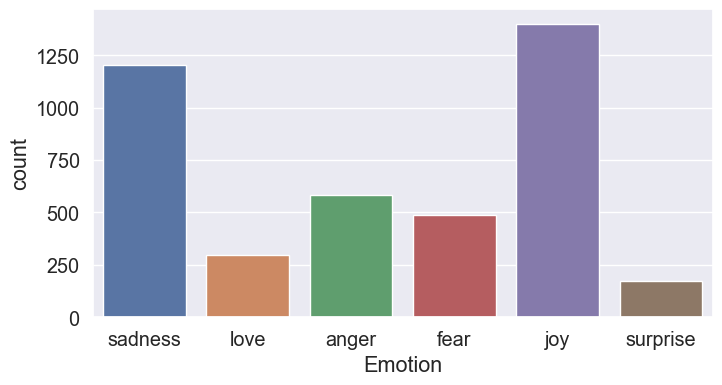

In [26]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);



In [27]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [28]:
#print the number of duplicated values 
df_test.duplicated().sum()

195

In [29]:

#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]



,Text,Emotion
115,i feel so idiotic for letting you and myself c...,sadness
229,i say that feelings dont dull selectively,sadness
397,i was living with when i first started coming ...,joy
671,i really went to cut it i feel it s unfortunat...,sadness
727,i say nothing then i my feelings are hurt i fe...,sadness
...,...,...
4094,i feel doubly honoured because both river of a...,joy
4113,i know who all think this way so i ve always f...,fear
4128,i feel like a rebellious year old that stands ...,anger
4137,i was feeling really troubled and down over wh...,sadness


In [30]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


6     387
5     384
7     383
3     356
8     338
4     321
9     278
10    276
2     261
11    222
12    180
13    151
1     111
14    110
15    103
16     68
17     66
18     43
19     27
20     27
0      24
21     18
22      6
23      6
25      1
Name: stop_words, dtype: int64

<Axes: ylabel='Frequency'>

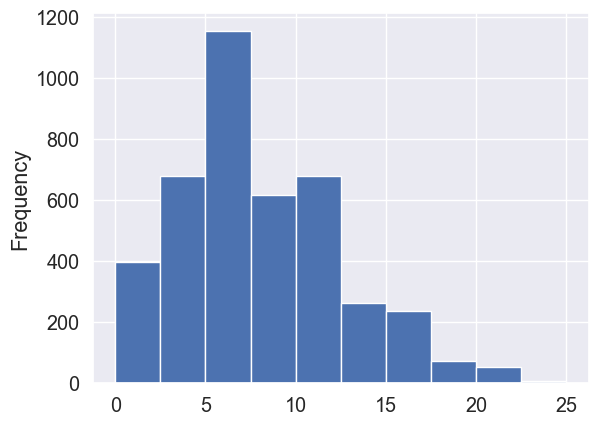

In [31]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

## Validation dataset

In [32]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

joy         1429
sadness     1177
fear         540
anger        528
love         322
surprise     149
Name: Emotion, dtype: int64

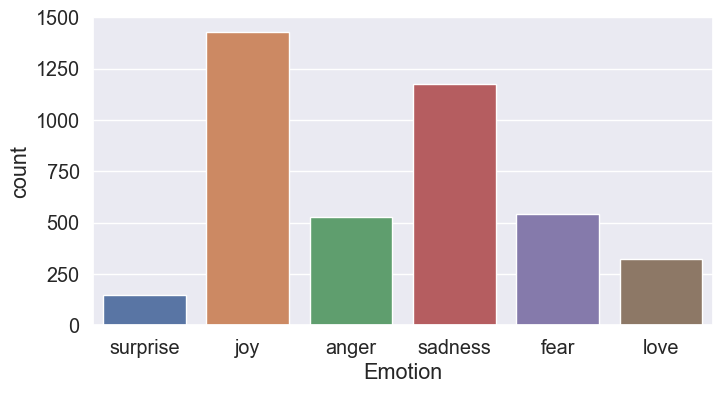

In [33]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [34]:
#print the number of null values in each column
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [35]:
#print the number of duplicated values 
df_val.duplicated().sum()

219

In [36]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
213,ive been feeling incredibly inadequate more so...,sadness
366,i was planning to make cookies this evening bu...,joy
421,i was part of the family and have a feeling of...,joy
438,i have a feeling she wasnt innocent in this,joy
494,i just didnt feel they got me which meant i wa...,fear
...,...,...
4115,i finally know what it feels like to be heartb...,sadness
4116,im feeling cranky cantankerous and resentful l...,anger
4123,i feel they look a little awkward just below,sadness
4137,i am not feeling more and more freaking relaxed,joy


In [37]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]


,Text,Emotion
603,i always feel stupid afterwards,sadness


In [38]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]


,Text,Emotion
1993,i feel honored or insulted,joy


In [39]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

/var/folders/hz/lcq0rx_90gq0lk9rm64pkzth0000gn/T/ipykernel_24926/2869941417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(index, axis = 0, inplace = True)


In [40]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]


7     353
5     347
4     329
6     319
8     311
9     301
3     289
10    277
2     245
11    222
Name: stop_words, dtype: int64

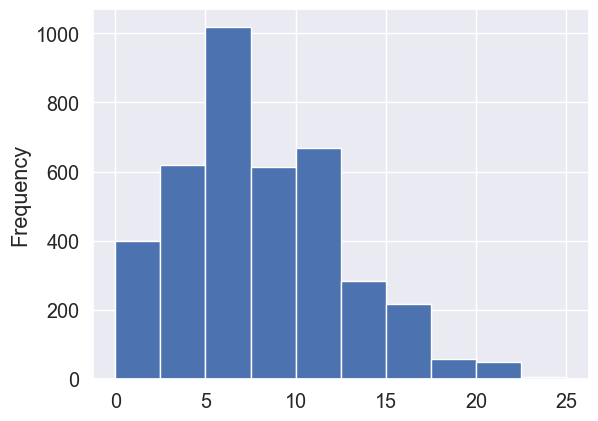

In [41]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

In [42]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [43]:
dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge
2,i wasnt feeling very optimistic but this would...,joy,both
6,i feel like that would be pretty cool,joy,both
21,i cant help but feel amused hmm,joy,both
22,i have no idea why but i get gastric pain when...,anger,both
24,i feel like ive shaken off some of the funk th...,fear,both
...,...,...,...
20289,i feel only reason skudrive is so popular is b...,joy,both
20297,i said earlier our bodies have gotten used to ...,joy,both
20298,i feel irritable or depressed during the cours...,anger,both
20299,i hope you do because otherwise your wife will...,sadness,both


In [44]:
dataframe_difference(df_train, df_val, which='both')

,Text,Emotion,_merge
18,i feel reluctant to supply this motion picture...,fear,both
26,i stand here i feel empty a class post count l...,sadness,both
27,i visit m ller in my country and go to the exp...,fear,both
56,i feel as if i must blog constantly for all my...,love,both
58,i feel very glad as in facebook we have many c...,joy,both
...,...,...,...
20294,i feel like i tend be more passionate about th...,joy,both
20295,i feel she said quickly i am so glad,joy,both
20300,i feel pathetic as if i have no meaning,sadness,both
20302,i hope you can feel the presence of loved ones...,love,both


In [45]:
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge
4,i feel extremely lost right now,sadness,both
17,i keep feeling weird sensations img src http s,fear,both
18,i found myself agreeing with a lot of her thou...,joy,both
20,i don t feel like i m a valuable person,joy,both
46,i am nowhere perfect but i feel helpless to sa...,sadness,both
...,...,...,...
3894,i to feel sympathetic about the children of th...,love,both
3897,i have only a few short weeks here and im feel...,sadness,both
3898,im feeling frantic because ive had no sleep,fear,both
3918,i feel like i ve been put in a bag and shaken ...,fear,both


In [46]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

    

In [47]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

/var/folders/hz/lcq0rx_90gq0lk9rm64pkzth0000gn/T/ipykernel_24926/3225203475.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Text=df.Text.apply(lambda text : lower_case(text))
/var/folders/hz/lcq0rx_90gq0lk9rm64pkzth0000gn/T/ipykernel_24926/3225203475.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Text=df.Text.apply(lambda text : remove_stop_words(text))
/var/folders/hz/lcq0rx_90gq0lk9rm64pkzth0000gn/T/ipykernel_24926/3225203475.py:49: SettingWithCopyWarning: 
A value is trying to be set on 

In [48]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [49]:
def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [50]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

Logistic Regression Model

In [51]:
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [52]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [53]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.911984567156981 



,F1 score
joy,0.906690
sadness,0.883770
anger,0.933060
fear,0.818182
love,0.939886
surprise,0.743860


In [ ]:
import pickle

# Pickle the tokenizer
with open('log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

In [54]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.93      0.88      0.91       583
        fear       0.90      0.86      0.88       488
         joy       0.89      0.98      0.93      1400
        love       0.94      0.72      0.82       299
     sadness       0.92      0.96      0.94      1204
    surprise       0.95      0.61      0.74       173

    accuracy                           0.91      4147
   macro avg       0.92      0.84      0.87      4147
weighted avg       0.91      0.91      0.91      4147



Decision Tree model


In [55]:
#Train the model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.9669640704123462 



,F1 score
joy,0.957770
sadness,0.953157
anger,0.976962
fear,0.948590
love,0.975529
surprise,0.928571


In [56]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.94      0.97      0.96       583
        fear       0.95      0.96      0.95       488
         joy       0.98      0.97      0.98      1400
        love       0.94      0.96      0.95       299
     sadness       0.97      0.98      0.98      1204
    surprise       0.96      0.90      0.93       173

    accuracy                           0.97      4147
   macro avg       0.96      0.96      0.96      4147
weighted avg       0.97      0.97      0.97      4147



Random Forest model


In [57]:
#Train the model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.9691343139619002 



,F1 score
joy,0.957035
sadness,0.952675
anger,0.978800
fear,0.951747
love,0.980165
surprise,0.930514


In [58]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.94      0.97      0.96       583
        fear       0.96      0.95      0.95       488
         joy       0.98      0.97      0.98      1400
        love       0.95      0.96      0.95       299
     sadness       0.98      0.99      0.98      1204
    surprise       0.97      0.89      0.93       173

    accuracy                           0.97      4147
   macro avg       0.96      0.95      0.96      4147
weighted avg       0.97      0.97      0.97      4147



In [59]:
import pickle

# Save the model to a file
with open('RF_model.pkl', 'wb') as f:
    pickle.dump(RF, f)

LSTM implementation


In [60]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [61]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [62]:
#print the labels after encoding 
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [63]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [64]:
print(y_train)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [65]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [66]:
#word index: A dictionary of words and their uniquely assigned integers.
#tokenizer.word_index

In [67]:
#word counts: A dictionary of words and their counts.
#tokenizer.word_counts

In [68]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

24452

In [69]:
#word docs: An integer count of the total number of documents(or rows) that were used to fit the Tokenizer.
#tokenizer.word_docs

In [70]:
#print the index of a single word
tokenizer.word_index['towards']

222

In [71]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[56],
 [51],
 [27],
 [2],
 [247],
 [389],
 [14],
 [106],
 [1364],
 [22],
 [386],
 [9],
 [4388]]

In [72]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(13, 16849)

In [74]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [75]:
#print the sentence after converting them to indexes
#sequences_train

In [76]:
df_test.shape

(4147, 2)

In [77]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [78]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16849


In [79]:
#before
sequences_train[0]

[56, 51, 27, 2, 247, 389, 14, 106, 1364, 22, 386, 9, 4388]

In [80]:
#after
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [81]:
# Read GloVE embeddings

path_to_glove_file = '/Users/kumarakrishnavaleti/desktop/PS1/glove/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [82]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 15332 words (1516 misses)


In [83]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          3369800   
                                                                 
 bidirectional (Bidirection  (None, 229, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 229, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [84]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [86]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=50,
                    callbacks=[callback]
                   )

OSError: No file or directory found at model.keras

In [ ]:
import pickle

# Pickle the tokenizer
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

In [ ]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

In [ ]:
sentence= 'my old brother is dead'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

In [ ]:
sentence= 'Today, I joined my new school. It was very nice and exciting, My class teacher was very nice to me. She introduced me to the entire class. I sat with Shalini, the monitor of the class. She helped in every way possible. She gave me her notebooks, shared her lunch with me. She even helped me with my classwork.'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

In [ ]:
def get_sentences(paragraph):
    sentences = nltk.sent_tokenize(paragraph)
    return sentences

In [ ]:
def print_emotions(paragraph):
    sentences = get_sentences(paragraph)
    for sentence in sentences:
        print(sentence)
        sentence = normalized_sentence(sentence)
        sentence = tokenizer.texts_to_sequences([sentence])
        sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
        result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
        proba =  np.max(model.predict(sentence))
        print(f"{result} : {proba}\n\n")

In [ ]:
print_emotions("Today, I joined my new school. It was very nice and exciting, My class teacher was very nice to me. She introduced me to the entire class. I sat with Shalini, the monitor of the class. She helped in every way possible. She gave me her notebooks, shared her lunch with me. She even helped me with my classwork.")

In [ ]:
print_emotions("Today was a mix of emotions. School was challenging, but I managed to find joy during lunch with my friends. In the evening, I had a great guitar lesson and received compliments on my progress. Ending the day with a cozy family dinner reminded me of the importance of love and support.")

In [ ]:
print_emotions("Wow, what an adventure-filled day! I went hiking with my friends in the nearby mountains. The scenic views took my breath away, and we had so much fun exploring the trails. We even discovered a hidden waterfall and took a refreshing dip in its crystal-clear waters. Nature truly has a way of rejuvenating the soul. Feeling tired but fulfilled, we gathered around a bonfire in the evening, sharing stories and laughter. It's moments like these that make me appreciate the beauty of friendship and the wonders of the world.")

In [ ]:
print_emotions("I took a walk today, it was pleasant. Although it started raining as soon as I came back home.")

In [ ]:
def print_emotion_percentages(paragraph):
    sentences = get_sentences(paragraph)
    total_sentences = len(sentences)
    emotions = {}

    sentences = get_sentences(paragraph)
    for sentence in sentences:
        print(sentence)
        sentence = normalized_sentence(sentence)
        sentence = tokenizer.texts_to_sequences([sentence])
        sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
        result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
        proba =  np.max(model.predict(sentence))

        if result in emotions:
            emotions[result] += 1
        else:
            emotions[result] = 1

        print(f"{result} : {proba}\n\n")

    for emotion, count in emotions.items():
        percentage = (count / total_sentences) * 100
        print(f"{emotion}: {percentage}%")



In [ ]:
print_emotion_percentages("Today was a mix of emotions. School was challenging, but I managed to find joy during lunch with my friends. In the evening, I had a great guitar lesson and received compliments on my progress. Ending the day with a cozy family dinner reminded me of the importance of love and support.")

In [ ]:
print_emotion_percentages("Wow, what an adventure-filled day! I went hiking with my friends in the nearby mountains. The scenic views took my breath away, and we had so much fun exploring the trails. We even discovered a hidden waterfall and took a refreshing dip in its crystal-clear waters. Nature truly has a way of rejuvenating the soul. Feeling tired but fulfilled, we gathered around a bonfire in the evening, sharing stories and laughter. It's moments like these that make me appreciate the beauty of friendship and the wonders of the world.")

In [ ]:
print_emotion_percentages("Today, I joined my new school. It was very nice and exciting, My class teacher was very nice to me. She introduced me to the entire class. I sat with Shalini, the monitor of the class. She helped in every way possible. She gave me her notebooks, shared her lunch with me. She even helped me with my classwork.")

In [ ]:
import pickle

# Pickle the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Pickle the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
